In this script we'll query the database with SQL and we'll visualize the output with ggplot2. There are two reason why I chose to do the visualization with R rather than Python: firstly, I am more proficient with ggplot2 than I am with seaborn or matplotlib and secondly I'd like to showcase my knowledge of multiple programming languages.

# Loading the libraries

We'll use the odbc library to connect to our database

In [1]:
suppressWarnings(suppressPackageStartupMessages(library(odbc)))
suppressWarnings(suppressPackageStartupMessages(library(tidyverse)))

# Connecting to the database

Let's have a look at the available drivers

In [2]:
sort(unique(odbcListDrivers()[[1]]))

[1] "Microsoft Access Driver (*.mdb, *.accdb)"              
 [2] "Microsoft Access Text Driver (*.txt, *.csv)"           
 [3] "Microsoft Excel Driver (*.xls, *.xlsx, *.xlsm, *.xlsb)"
 [4] "MySQL ODBC 8.0 ANSI Driver"                            
 [5] "MySQL ODBC 8.0 Unicode Driver"                         
 [6] "ODBC Driver 17 for SQL Server"                         
 [7] "PostgreSQL ANSI"                                       
 [8] "PostgreSQL ANSI(x64)"                                  
 [9] "PostgreSQL Unicode"                                    
[10] "PostgreSQL Unicode(x64)"                               
[11] "SQL Server"                                            
[12] "SQL Server Native Client 11.0"                         
[13] "SQL Server Native Client RDA 11.0"

Let's connect to our postgreSQL database by using the "PostgreSQL Unicode(x64)" driver

In [3]:
con <- DBI::dbConnect(odbc(),
                      Driver   = "PostgreSQL Unicode(x64)",
                      Server   = Sys.getenv('rds_postgres_imdb_host'),
                      Database = "postgres_imdb",
                      UID      = Sys.getenv('rds_postgres_imdb_username'),
                      PWD      = Sys.getenv('rds_postgres_imdb_psw'),
                      Port     = 5432)

The tables in our database

In [4]:
dbListTables(con)

[1] "films"  "people" "stats"

# Querying and visualizing the data

## Genre popularity across time

Let's see how the absolute frequency for each genre changed across time. Due to the large number of genres in the database, we'll focus on the five most common ones. The 'genre' column often contains multiple values separated by a semicolon, so we'll need to split and unnest it. 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



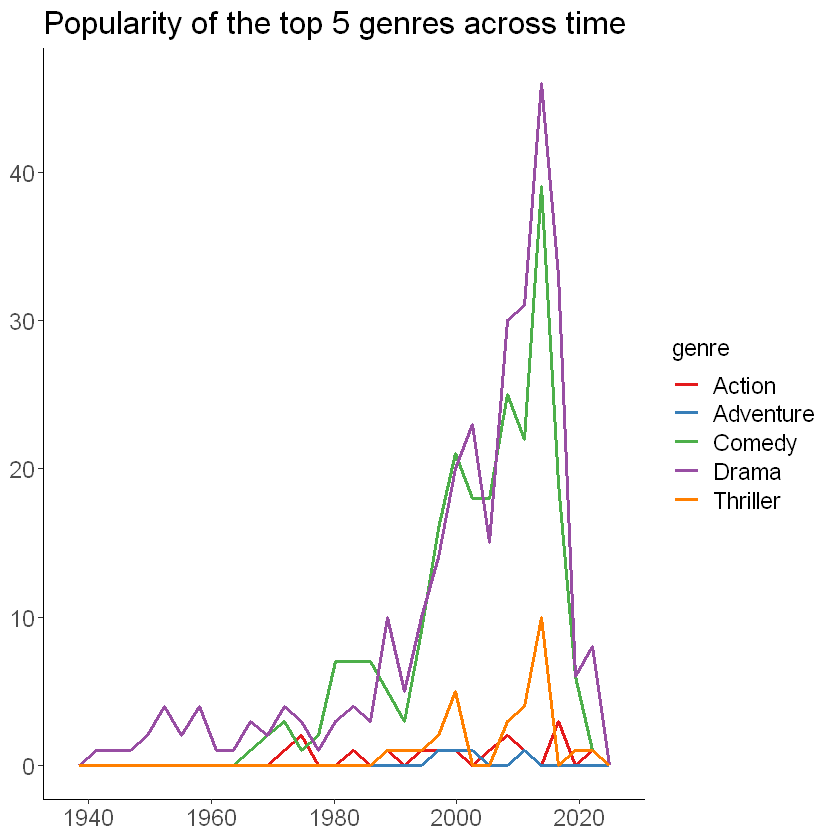

In [5]:
query  <- "WITH CTE AS (
                        SELECT UNNEST(STRING_TO_ARRAY(genre, ';')) genre,
                               COUNT(*)
                        FROM films
                        GROUP BY 1
                        ORDER BY 2 DESC
                        LIMIT 5
                        )

           SELECT EXTRACT(YEAR FROM release_date :: DATE) AS year,
                  UNNEST(STRING_TO_ARRAY(genre, ';')) genre
           FROM films
           WHERE genre IN (SELECT genre FROM CTE)"

dbGetQuery(conn = con, statement = query) %>% 
ggplot(aes(x = year, colour = genre)) +
geom_freqpoly(size = 1) +
scale_x_continuous(breaks = seq(1920, 2020, 20)) +
ggtitle("Popularity of the top 5 genres across time") +
theme_classic() +
theme(title = element_text(size = 16),
      axis.title.x = element_blank(),
      axis.title.y = element_blank(),
      axis.text.x = element_text(size = 14),
      axis.text.y = element_text(size = 14),
      legend.title = element_text(size = 14),
      legend.text = element_text(size = 14)) +
scale_colour_brewer(palette = "Set1")

## Decades with most films

Let's create a new variable called 'decade' with a case when statement and let's calculate the absolute and relative frequencies by decade

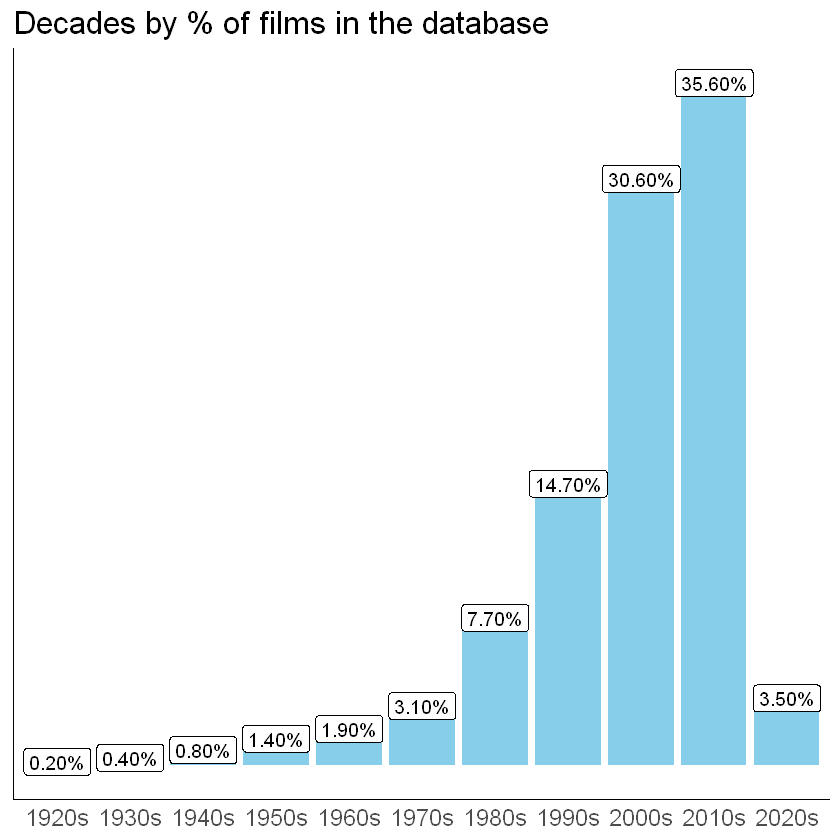

In [6]:
query <- "SELECT CASE WHEN EXTRACT(YEAR FROM release_date :: DATE) >= 2020 THEN '2020s'
                      WHEN EXTRACT(YEAR FROM release_date :: DATE) >= 2010 AND EXTRACT(YEAR FROM release_date :: DATE) < 2020 THEN '2010s'
                      WHEN EXTRACT(YEAR FROM release_date :: DATE) >= 2000 AND EXTRACT(YEAR FROM release_date :: DATE) < 2010 THEN '2000s'
                      WHEN EXTRACT(YEAR FROM release_date :: DATE) >= 1990 AND EXTRACT(YEAR FROM release_date :: DATE) < 2000 THEN '1990s'
                      WHEN EXTRACT(YEAR FROM release_date :: DATE) >= 1980 AND EXTRACT(YEAR FROM release_date :: DATE) < 1990 THEN '1980s'
                      WHEN EXTRACT(YEAR FROM release_date :: DATE) >= 1970 AND EXTRACT(YEAR FROM release_date :: DATE) < 1980 THEN '1970s'
                      WHEN EXTRACT(YEAR FROM release_date :: DATE) >= 1960 AND EXTRACT(YEAR FROM release_date :: DATE) < 1970 THEN '1960s'
                      WHEN EXTRACT(YEAR FROM release_date :: DATE) >= 1950 AND EXTRACT(YEAR FROM release_date :: DATE) < 1960 THEN '1950s'
                      WHEN EXTRACT(YEAR FROM release_date :: DATE) >= 1940 AND EXTRACT(YEAR FROM release_date :: DATE) < 1950 THEN '1940s'
                      WHEN EXTRACT(YEAR FROM release_date :: DATE) >= 1930 AND EXTRACT(YEAR FROM release_date :: DATE) < 1940 THEN '1930s'
                      WHEN EXTRACT(YEAR FROM release_date :: DATE) >= 1920 AND EXTRACT(YEAR FROM release_date :: DATE) < 1930 THEN '1920s'
                      ELSE '1910s or earlier' END AS Decade,
                  COUNT(*),
                  ROUND(COUNT(*) :: NUMERIC / (SELECT COUNT(*) FROM films), 3) percentage
          FROM films
          GROUP BY 1
          ORDER BY 2 DESC"

dbGetQuery(conn = con, statement = query)  %>% 
mutate(label = scales::percent(percentage)) %>% 
ggplot(aes(x = decade, y = percentage, label = label)) +
geom_col(fill = "skyblue") +
geom_label(size = 4) +
theme_classic() +
ggtitle("Decades by % of films in the database") +
theme(title = element_text(size = 16),
      axis.title.y = element_blank(),
      axis.text.y = element_blank(),
      axis.ticks.y = element_blank(),
      axis.title.x = element_blank(),
      axis.ticks.x = element_blank(),
      axis.text.x = element_text(size = 14))

## Countries with most films in the database

Let's now visualize how the number of films by country changed across time. 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



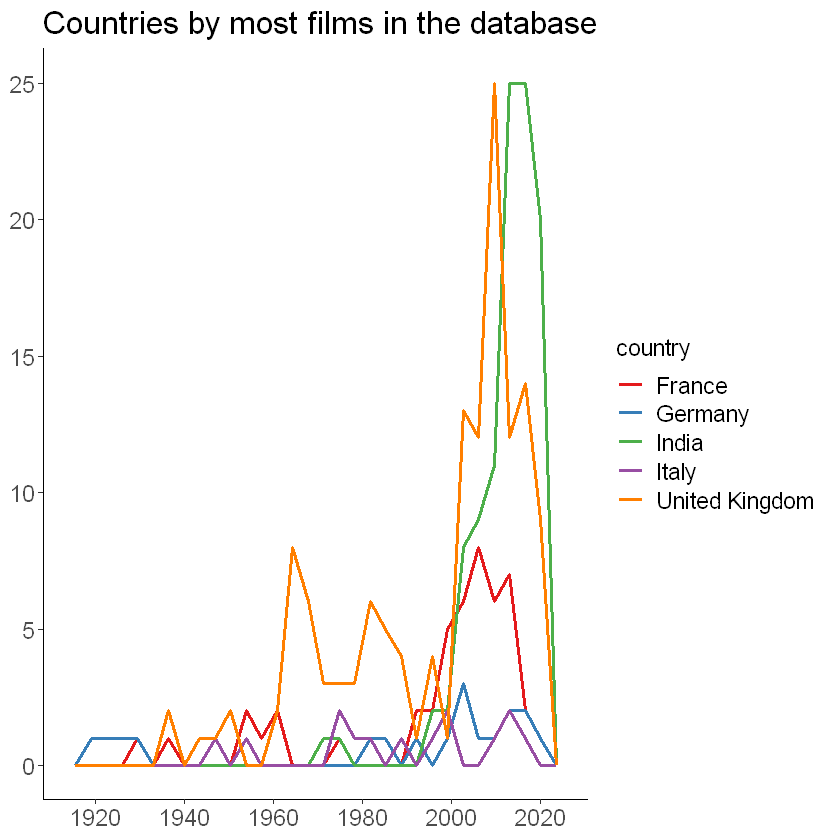

In [7]:
query <- "WITH CTE AS (
                        SELECT UNNEST(STRING_TO_ARRAY(country, ';')) country,
                               COUNT(*) n_of_films
                        FROM films
                        WHERE country NOT LIKE '%United States of America%'
                        GROUP BY 1
                        ORDER BY 2 DESC
                        LIMIT 5
                               
                        )

          SELECT EXTRACT(YEAR FROM release_date :: DATE) AS year,
                 UNNEST(STRING_TO_ARRAY(country, ';')) AS country
          FROM films
          WHERE country IN (SELECT country FROM CTE)"

dbGetQuery(conn = con, statement = query) %>% 
ggplot(aes(x = year, colour = country)) +
geom_freqpoly(size = 1) +
scale_x_continuous(breaks = seq(1920, 2020, 20)) +
ggtitle("Countries by most films in the database") +
theme_classic() +
theme(title = element_text(size = 16),
      legend.title = element_text(size = 14),
      legend.text = element_text(size = 14),
      axis.title.x = element_blank(),
      axis.text.x = element_text(size = 14),
      axis.text.y = element_text(size = 14),
      axis.title.y = element_blank()) +
scale_colour_brewer(palette = "Set1")

## Correlation between box office revenue and averate rating

Is there a correlation between box office revenue and the average IMDB rating? Let's find out by drawing a scatterplot for films with less than one billion dollars in revenue (outliers may distort the correlation)

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



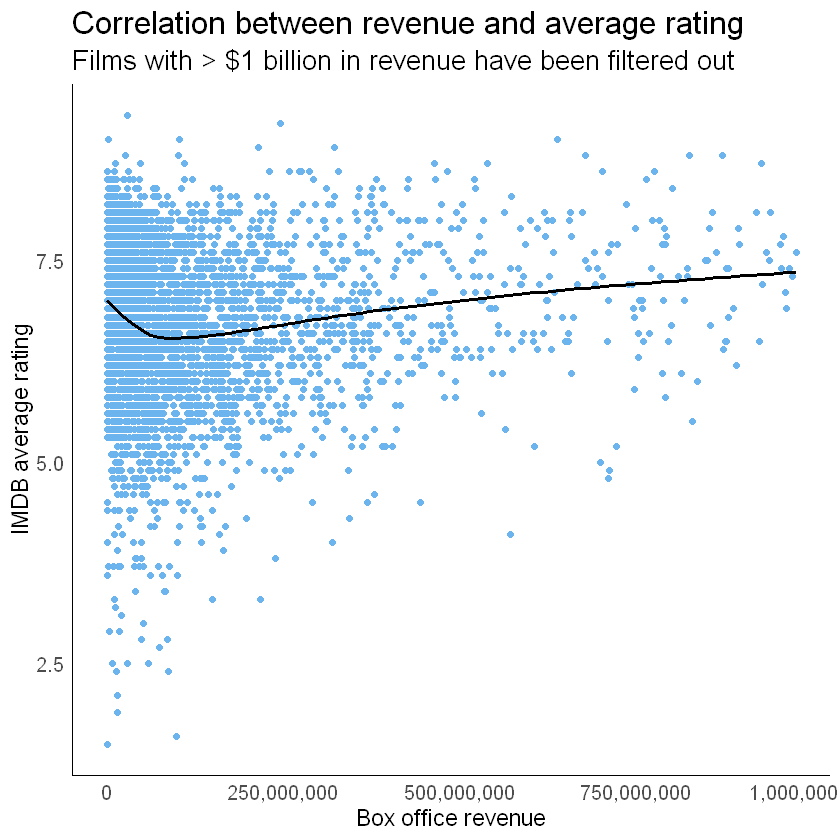

In [8]:
query <- "SELECT revenue, imdb_rating 
          FROM stats
          WHERE revenue > 0 and revenue < 1000000000"

dbGetQuery(conn = con, statement = query)  %>% 
ggplot(aes(x = as.numeric(revenue), y = as.numeric(imdb_rating))) +
geom_point(colour = "#6CB4EE") +
geom_smooth(se = FALSE, colour = "black") +
scale_x_continuous(labels = scales::comma) +
theme_classic() +
labs(title = "Correlation between revenue and average rating",
     subtitle = "Films with > $1 billion in revenue have been filtered out",
     x = "Box office revenue",
     y = "IMDB average rating") +
theme(title = element_text(size = 16),
      axis.title.y = element_text(size = 14),
      axis.text.y = element_text(size = 12),
      axis.ticks.y = element_blank(),
      axis.title.x = element_text(size = 14),
      axis.text.x = element_text(size = 12),
      axis.ticks.x = element_blank())

## Directors with highest box office revenue for each genre

For each genre in the database we'll find out the director with the highest total boxoffice revenue.

In [9]:
query <- "WITH CTE AS(SELECT UNNEST(STRING_TO_ARRAY(genre, ';')) genre,
                             director,
                             SUM(revenue) total_revenue,
                             STRING_AGG(title, ' | ') films
                      FROM films
                      JOIN people USING (id)
                      JOIN stats USING (id)
                      GROUP BY 1, 2),

        CTE_TWO AS (SELECT genre, 
                           MAX(total_revenue) max_revenue
                    FROM CTE
                    GROUP BY 1)

        SELECT CTE_TWO.genre, 
               CTE.director, 
               CTE_TWO.max_revenue, 
               CTE.films
        FROM CTE_TWO
        JOIN CTE 
        ON CTE.total_revenue = CTE_TWO.max_revenue AND CTE.genre = CTE_TWO.genre
        WHERE CTE_TWO.max_revenue > 0"

dbGetQuery(conn = con, statement = query)

genre,director,max_revenue,films
<chr>,<chr>,<dbl>,<chr>
Action,Anthony Russo;Joe Russo,6712103066,Captain America: Civil War | Avengers: Endgame | Captain America: The Winter Soldier | Avengers: Infinity War
Adventure,Steven Spielberg,7076819634,Jaws | Indiana Jones and the Kingdom of the Crystal Skull | The Lost World: Jurassic Park | E.T. the Extra-Terrestrial | Indiana Jones and the Last Crusade | The BFG | War of the Worlds | A.I. Artificial Intelligence | Hook | Raiders of the Lost Ark | Jurassic Park | Indiana Jones and the Temple of Doom | The Adventures of Tintin | Ready Player One
Animation,Jennifer Lee;Chris Buck,2724245942,Frozen II | Frozen
Comedy,Robert Zemeckis,2511057961,Back to the Future Part II | Roald Dahl's The Witches | Back to the Future | Romancing the Stone | Forrest Gump | Back to the Future Part III | Death Becomes Her | Who Framed Roger Rabbit | The Polar Express
Crime,Justin Lin,2657529145,The Fast and the Furious: Tokyo Drift | F9 | Fast Five | Fast & Furious | Fast & Furious 6
Documentary,Michael Moore,299986377,Bowling for Columbine | Sicko | Capitalism: A Love Story | Fahrenheit 9/11
Drama,Christopher Nolan,3798272403,Dunkirk | Batman Begins | The Prestige | The Dark Knight Rises | The Dark Knight | Following | Interstellar
Family,Jon Favreau,2872663549,The Jungle Book | The Lion King | Elf | Zathura: A Space Adventure
Fantasy,David Yates,5987430316,Harry Potter and the Half-Blood Prince | Harry Potter and the Deathly Hallows: Part 1 | Fantastic Beasts and Where to Find Them | The Legend of Tarzan | Harry Potter and the Order of the Phoenix | Harry Potter and the Deathly Hallows: Part 2 | Fantastic Beasts: The Crimes of Grindelwald


## Directors with most films in the database

Who are the directors with most films among the top 5000 most rated films on IMDB? Again we'll need to use split and unnest.

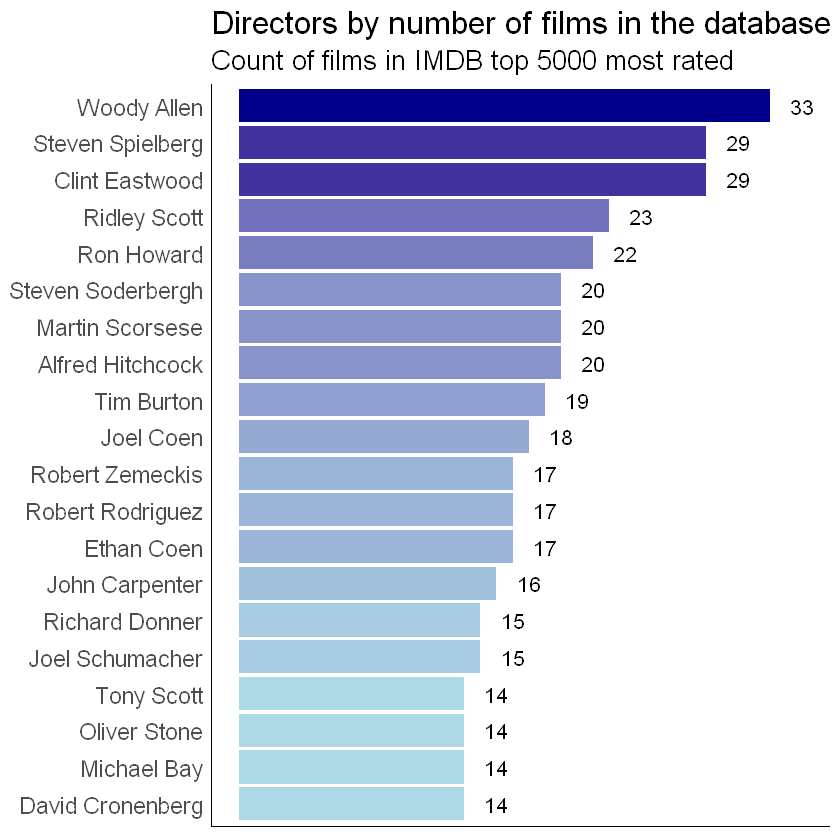

In [10]:
query <- "SELECT UNNEST(STRING_TO_ARRAY(director, ';')) director, 
          COUNT(*) n_of_films
          FROM people
          GROUP BY 1
          ORDER BY 2 DESC
          LIMIT 20"

dbGetQuery(conn = con, statement = query) %>% 
  ggplot(aes(x = fct_reorder(director, n_of_films), y = as.numeric(n_of_films), fill = as.numeric(n_of_films))) +
  geom_col() +
  geom_text(aes(label = as.factor(n_of_films)), nudge_y = 2, size = 4.5) +
  coord_flip() +
  theme_classic() +
  labs(title = "Directors by number of films in the database",
       subtitle = "Count of films in IMDB top 5000 most rated") +
  theme(title = element_text(size = 16),
        legend.position = "none",
        axis.title.x = element_blank(),
        axis.title.y = element_blank(),
        axis.text.x = element_blank(),
        axis.text.y = element_text(size = 14),
        axis.ticks.x = element_blank(),
        axis.ticks.y = element_blank()) +
  scale_fill_gradient(low = "light blue", high = "dark blue")

## Directors with highest average ratings

Now we'll calculate the average film rating for directors having at least 5 films in the dataset. We'll also add a third column containing the titles and year of those films.

In [11]:
query <- "SELECT DENSE_RANK() OVER(ORDER BY SUM(revenue) DESC) rank,
                 UNNEST(STRING_TO_ARRAY(director, ';')) director,
                 TRUNC(SUM(revenue) :: NUMERIC, -7) total_revenue, 
                 STRING_AGG(title || ' (' || EXTRACT(YEAR FROM release_date :: DATE) || ')', ' | ') films
          FROM people 
          JOIN stats USING (id) 
          JOIN films USING (id)
          GROUP BY 2 
          ORDER BY 3 DESC
          LIMIT 20"

output_two <- dbGetQuery(conn = con, statement = query)
output_two

rank,director,total_revenue,films
<int64>,<chr>,<dbl>,<chr>
1,Steven Spielberg,1.033e+10,War Horse (2011) | Raiders of the Lost Ark (1981) | Jurassic Park (1993) | Catch Me If You Can (2002) | Indiana Jones and the Last Crusade (1989) | Bridge of Spies (2015) | Jaws (1975) | E.T. the Extra-Terrestrial (1982) | Minority Report (2002) | Indiana Jones and the Temple of Doom (1984) | Indiana Jones and the Kingdom of the Crystal Skull (2008) | The Terminal (2004) | War of the Worlds (2005) | Ready Player One (2018) | The Lost World: Jurassic Park (1997) | Saving Private Ryan (1998) | The Color Purple (1985) | The BFG (2016) | A.I. Artificial Intelligence (2001) | Empire of the Sun (1987) | Lincoln (2012) | Hook (1991) | The Adventures of Tintin (2011) | Munich (2005) | Amistad (1997) | Close Encounters of the Third Kind (1977) | 1941 (1979) | Schindler's List (1993) | The Post (2017)
2,Joe Russo,6.840e+09,"Avengers: Infinity War (2018) | Avengers: Endgame (2019) | Captain America: Civil War (2016) | Captain America: The Winter Soldier (2014) | You, Me and Dupree (2006)"
2,Anthony Russo,6.840e+09,"Avengers: Endgame (2019) | You, Me and Dupree (2006) | Captain America: Civil War (2016) | Captain America: The Winter Soldier (2014) | Avengers: Infinity War (2018)"
3,Peter Jackson,6.560e+09,The Lovely Bones (2009) | The Lord of the Rings: The Return of the King (2003) | Heavenly Creatures (1994) | Braindead (1992) | The Lord of the Rings: The Two Towers (2002) | The Frighteners (1996) | King Kong (2005) | The Hobbit: The Desolation of Smaug (2013) | Bad Taste (1987) | The Lord of the Rings: The Fellowship of the Ring (2001) | They Shall Not Grow Old (2018) | The Hobbit: The Battle of the Five Armies (2014) | The Hobbit: An Unexpected Journey (2012)
4,Michael Bay,6.450e+09,The Rock (1996) | Bad Boys II (2003) | Transformers (2007) | 13 Hours: The Secret Soldiers of Benghazi (2016) | Transformers: Revenge of the Fallen (2009) | Transformers: The Last Knight (2017) | Pain & Gain (2013) | Pearl Harbor (2001) | Armageddon (1998) | Transformers: Dark of the Moon (2011) | The Island (2005) | 6 Underground (2019) | Transformers: Age of Extinction (2014) | Bad Boys (1995)
5,James Cameron,6.280e+09,Terminator 2: Judgment Day (1991) | Aliens (1986) | Titanic (1997) | The Abyss (1989) | True Lies (1994) | Avatar (2009) | The Terminator (1984)
6,David Yates,5.980e+09,Harry Potter and the Deathly Hallows: Part 2 (2011) | Fantastic Beasts and Where to Find Them (2016) | Harry Potter and the Deathly Hallows: Part 1 (2010) | The Legend of Tarzan (2016) | Fantastic Beasts: The Crimes of Grindelwald (2018) | Harry Potter and the Half-Blood Prince (2009) | Harry Potter and the Order of the Phoenix (2007)
7,Christopher Nolan,5.140e+09,Following (1999) | Dunkirk (2017) | Batman Begins (2005) | Interstellar (2014) | Tenet (2020) | The Dark Knight Rises (2012) | Memento (2000) | The Prestige (2006) | The Dark Knight (2008) | Insomnia (2002) | Inception (2010)
8,J.J. Abrams,4.650e+09,Star Trek Into Darkness (2013) | Star Wars: The Rise of Skywalker (2019) | Super 8 (2011) | Star Wars: The Force Awakens (2015) | Star Trek (2009) | Mission: Impossible III (2006)


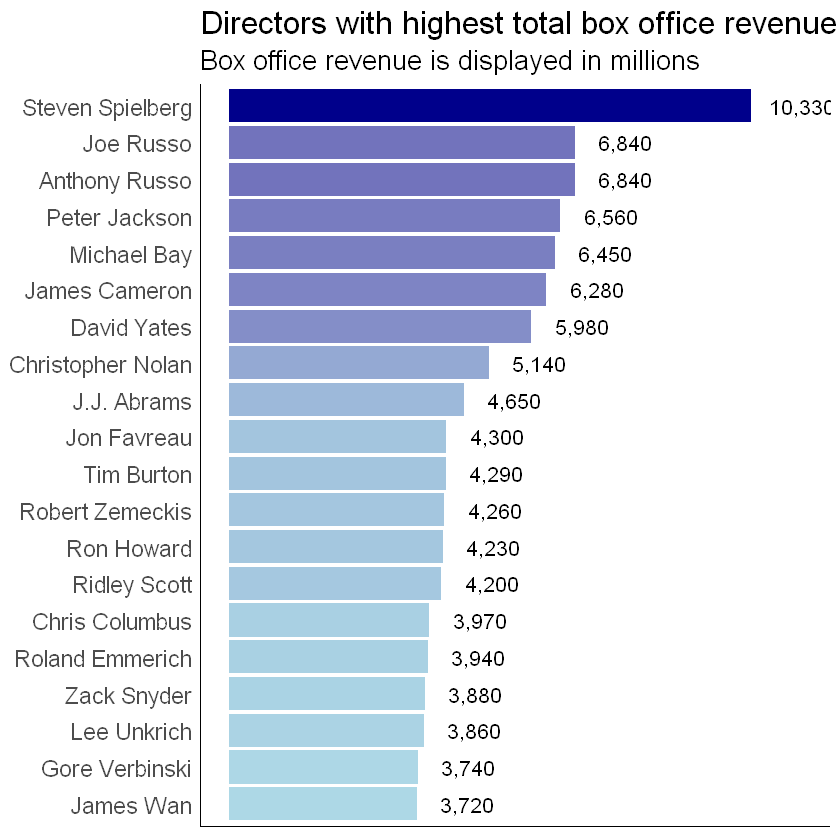

In [12]:
output_two %>% 
mutate(label = str_replace(string = scales::comma(total_revenue), pattern = ",000,000", replacement = ""))  %>% 
ggplot(aes(x = fct_reorder(director, total_revenue), 
           y = total_revenue, 
           fill = total_revenue)) +
geom_col() +
geom_text(aes(label = label), nudge_y = 1000000000, size = 4.5) +
coord_flip() +
scale_y_continuous(labels = scales::comma) +
theme_classic() +
labs(title = "Directors with highest total box office revenue",
     subtitle = "Box office revenue is displayed in millions") +
theme(legend.position = 'none',
      title = element_text(size = 16),
      axis.text.y = element_text(size = 14),
      axis.text.x = element_blank(),
      axis.title.x = element_blank(),
      axis.title.y = element_blank(),
      axis.ticks.x = element_blank(),
      axis.ticks.y = element_blank()) +
scale_fill_gradient(low = "light blue", high = "dark blue")

## People with most film credits

Let's now find out who the people with most film credits are. We'll include directors, producers, cinematographers, costume designers etc. To do this, we'll first unpivot all the columns from the 'people' table, then we'll split and unnest the resulting column and count the occurrences of each name.

Mark Falvo and Jimmy Star mostly work as extras in big Hollywood productions.

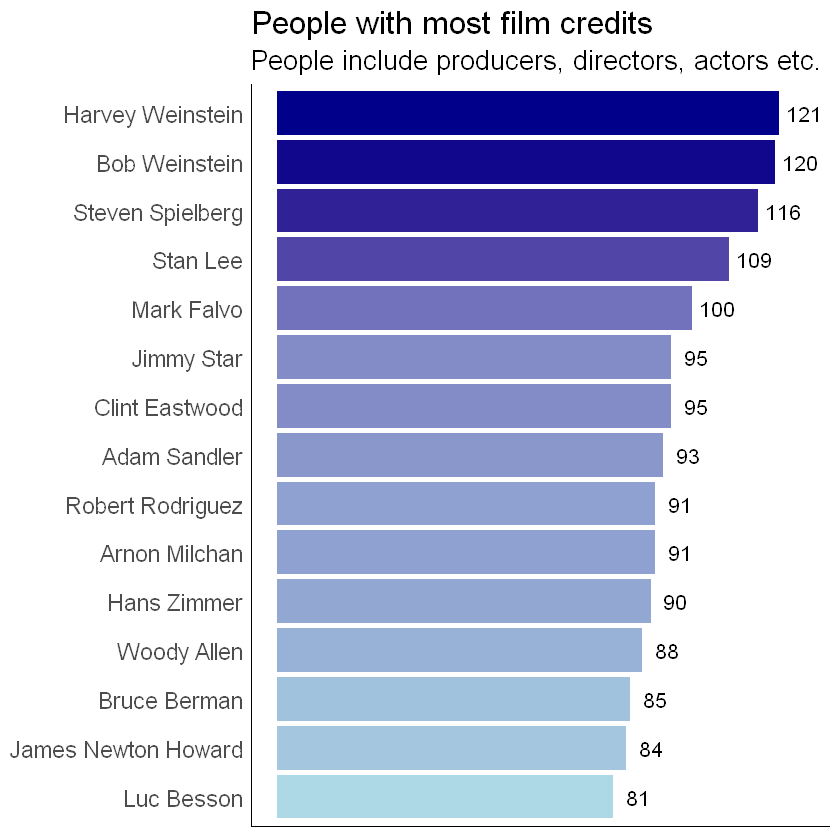

In [13]:
query  <-  "WITH CTE AS (SELECT UNNEST(ARRAY[director, writer, actors, cinematographer, editor, composer, 
                                 production_designer, art_director, costume_designer, producers]) people
FROM people)

SELECT UNNEST(STRING_TO_ARRAY(people, ';')) people, 
       COUNT(*) n_of_credits
FROM CTE
GROUP BY 1 
ORDER BY 2 DESC
LIMIT 15"

dbGetQuery(conn = con, statement = query) %>% 
ggplot(aes(x = fct_reorder(people, n_of_credits), y = as.numeric(n_of_credits), fill = as.numeric(n_of_credits))) +
geom_col() +
geom_text(aes(label = as.numeric(n_of_credits)), nudge_y = 6, size = 4.5) +
coord_flip() +
theme_classic() +
labs(title = "People with most film credits",
     subtitle = "People include producers, directors, actors etc.") +
theme(title = element_text(size = 16),
      legend.position = "none",
      axis.title.x = element_blank(),
      axis.title.y = element_blank(),
      axis.text.x = element_blank(),
      axis.text.y = element_text(size = 14),
      axis.ticks.x = element_blank(),
      axis.ticks.y = element_blank()) +
scale_fill_gradient(low = "light blue", high = "dark blue")